# ArcGIS Deep Learning Pre-trained Models

## Acceder a las imágenes de las cámaras de la DGT

### Acceder a la capa de ArcGIS Online

Importo la API de Python para poder acceder a los datos de ArcGIS Online

In [23]:
from arcgis.gis import GIS
gis = GIS("home")

Accedo al servicio de Cámaras de Tráfico de la DGT

In [24]:
idServicio = "13c0065c40984c34baae3493061646ce"
camarasTrafico = gis.content.get(idServicio).layers[0]
camarasTrafico

<FeatureLayer url:"https://services1.arcgis.com/YFraetVkEAF1lMag/arcgis/rest/services/Camaras_DGT_Albacete/FeatureServer/0">

### Accedo a la tabla de la capa

Importo la librería pandas para poder trabajar con datos tabulares de forma sencilla

In [25]:
import pandas as pd

Voy a hacer una query de los datos a mi capa con el método query

In [54]:
camarasTraficoDF = camarasTrafico.query(as_df=True, where="FID<3")
camarasTraficoDF

,OBJECTID,url,pk,direction,road,region,cameraId,lng,lat,FID,x,y,Cars,Trucks,Buses,Pedestrians,stop_sign,SHAPE
0,1,http://www.dgt.es/es/el-trafico/camaras-de-tra...,1.0,Creciente,A-30,Albacete,http://infocar.dgt.es/etraffic/data/camaras/32...,-1.818637,38.96774,1,-1.818637,38.96774,0,0,0,0,0,"{""x"": -202449.77820000052, ""y"": 4717051.657300..."
1,2,http://www.dgt.es/es/el-trafico/camaras-de-tra...,4.4,Decreciente,A-30,Albacete,http://infocar.dgt.es/etraffic/data/camaras/32...,-1.830648,38.944813,2,-1.830648,38.944813,0,0,0,0,0,"{""x"": -203786.75869999823, ""y"": 4713769.588399..."


### Adquirir la imagen de la URL

Ahora vamos a hacer la petición de la URL para sacar la imagen

Accedo al primer registro del DataFrame

In [63]:
print(camarasTraficoDF.iloc[1,6])

http://infocar.dgt.es/etraffic/data/camaras/329.jpg


Ahora tengo que acceder a la imagen de la url

In [41]:
from PIL import Image
import requests
from io import BytesIO
import os

In [65]:
respuestaServicio = requests.get(camarasTraficoDF.iloc[1,6])

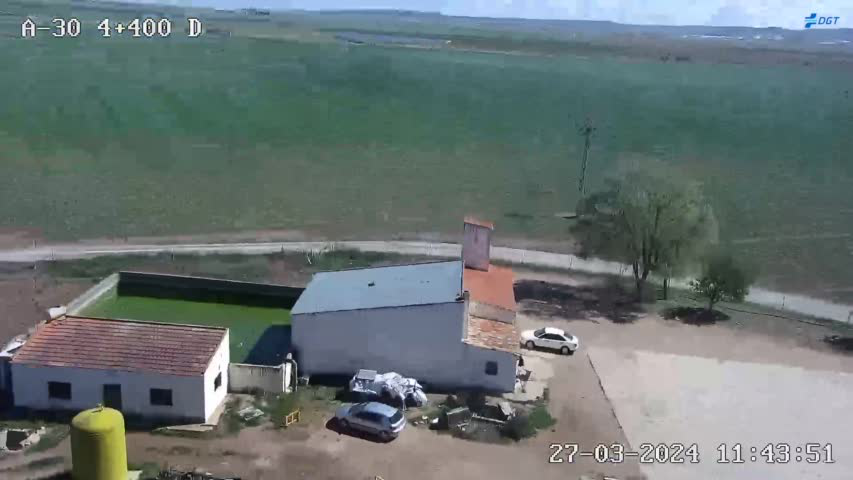

In [66]:
# MOVER DE AQUI
workingDirectory = 'C:/Users/alvaro.gutierrez/DatosLocal/Imagenes-deep-learning/DeepLearningPackage'
imagenDGT = Image.open(BytesIO(respuestaServicio.content))
imagenDGT

In [44]:

imagenDGT.save(os.path.join(workingDirectory,'imagenDGT.jpg'))


In [46]:
urlImagen = os.path.join(workingDirectory,'imagenDGT.jpg')
urlImagen

'C:/Users/alvaro.gutierrez/DatosLocal/Imagenes-deep-learning/DeepLearningPackage\\imagenDGT.jpg'

Importo arcpy para poder trabajar con las herramientas de geoprocesamiento de ArcGIS

In [35]:
import arcpy
from arcpy.ia import *

Activo la propiedad de sobreescribir dentro de la fgdb para que se sobreescriba cualquier tipo de resultado en mi gdb

In [36]:
arcpy.env.overwriteOutput = True

Chequeo si tengo las extensiones necesarias

In [37]:
arcpy.CheckOutExtension("ImageExt")
arcpy.CheckOutExtension("ImageAnalyst")

'CheckedOut'

Establezco el entorno de trabajo, en mi caso la FGDB del proyecto

In [38]:
arcpy.env.workspace = "C:\\Users\\alvaro.gutierrez\\OneDrive - ESRI ESPAÑA Soluciones Geoespaciales S.L\\Documentos\\ArcGIS\\Projects\\GeoAI - Pruebas\\GeoAI - Pruebas.gdb"

Importo la Imagen que vamos a utilizar para realizar el análisis

In [47]:
# PNOA_MA_OF_ETRS89_HU30_h25_0559_2_tif = arcpy.Raster("C:/Users/alvaro.gutierrez/DatosLocal/Imagenes-deep-learning/344.jpg")
imagenEntradaModelo = arcpy.Raster(urlImagen)

Importo el Modelo pre-entrenado descargado del Living Atlas

In [48]:
TextSAM_dlpk = "C:/Users/alvaro.gutierrez/DatosLocal/Imagenes-deep-learning/DeepLearningPackage/TextSAM.dlpk"

Determino la ruta de salida de los polígonos al aplicar la herramienta

In [49]:
nombreDeLaCapaNueva = 'PruebaAutomatica'
rutaDeSalida = f"C:\\Users\\alvaro.gutierrez\\OneDrive - ESRI ESPAÑA Soluciones Geoespaciales S.L\\Documentos\\ArcGIS\\Projects\\GeoAI - Pruebas\\GeoAI - Pruebas.gdb\\{nombreDeLaCapaNueva}"

Aplico el Modelo configurando los parámetros

In [50]:

with arcpy.EnvManager( 
  scratchWorkspace="C:\\Users\\alvaro.gutierrez\\OneDrive - ESRI ESPAÑA Soluciones Geoespaciales S.L\\Documentos\\ArcGIS\\Projects\\GeoAI - Pruebas\\GeoAI - Pruebas.gdb"
  ):
  arcpy.ia.DetectObjectsUsingDeepLearning(
    imagenEntradaModelo, 
    rutaDeSalida, 
    TextSAM_dlpk, 
    [
      ["text_prompt", "car"], 
      ["padding", "256"], 
      ["batch_size", "4"], 
      ["box_threshold", "0,4"], 
      ["text_threshold", "0,2"], 
      ["box_nms_thresh", "0,7"]
    ], 
    "NO_NMS", 
    "Confidence", 
    "Class", 
    0, 
    "PROCESS_AS_MOSAICKED_IMAGE"
  )

final text_encoder_type: bert-base-uncased
final text_encoder_type: bert-base-uncased
final text_encoder_type: bert-base-uncased
final text_encoder_type: bert-base-uncased


## Contar los coches

In [51]:
arcpy.GetCount_management("PruebaAutomatica").getOutput(0)

'1'

In [67]:
def DetectDGT (imagenEntradaModelo, rutaDeSalida ,prompt):
  with arcpy.EnvManager( 
    scratchWorkspace="C:\\Users\\alvaro.gutierrez\\OneDrive - ESRI ESPAÑA Soluciones Geoespaciales S.L\\Documentos\\ArcGIS\\Projects\\GeoAI - Pruebas\\GeoAI - Pruebas.gdb"
    ):
    arcpy.ia.DetectObjectsUsingDeepLearning(
      imagenEntradaModelo, 
      rutaDeSalida, 
      TextSAM_dlpk, 
      [
        ["text_prompt", prompt], 
        ["padding", "256"], 
        ["batch_size", "4"], 
        ["box_threshold", "0,4"], 
        ["text_threshold", "0,2"], 
        ["box_nms_thresh", "0,7"]
      ], 
      "NO_NMS", 
      "Confidence", 
      "Class", 
      0, 
      "PROCESS_AS_MOSAICKED_IMAGE"
    )

In [68]:
workingDirectory2 = 'C:/Users/alvaro.gutierrez/DatosLocal/Imagenes-deep-learning/ImagenesDGT'

for FID in range(len(camarasTraficoDF)):
  response = requests.get(camarasTraficoDF.iloc[FID,6])
  responseImage = Image.open(BytesIO(response.content))
  responseImage.save(os.path.join(workingDirectory2,f'imagenDGT{FID}.jpg'))
  urlIm = os.path.join(workingDirectory2,f'imagenDGT{FID}.jpg')
  layerName = f'PruebaBucle{FID}'
  layerOutputUrl = f"C:\\Users\\alvaro.gutierrez\\OneDrive - ESRI ESPAÑA Soluciones Geoespaciales S.L\\Documentos\\ArcGIS\\Projects\\GeoAI - Pruebas\\GeoAI - Pruebas.gdb\\{layerName}"
  DetectDGT(urlIm, layerOutputUrl,'car')
  numeroCoches = arcpy.GetCount_management(layerName).getOutput(0)
  print(numeroCoches)
  


final text_encoder_type: bert-base-uncased
final text_encoder_type: bert-base-uncased
final text_encoder_type: bert-base-uncased
final text_encoder_type: bert-base-uncased
0
final text_encoder_type: bert-base-uncased
final text_encoder_type: bert-base-uncased
final text_encoder_type: bert-base-uncased
final text_encoder_type: bert-base-uncased
